## 实验十二：EM算法和高斯混合聚类

In [1]:
import os
os.environ['OMP_NUM_THREADS'] = '6'
import numpy as np
import matplotlib.pyplot as plt

### 1. 基于sklearn的高斯混合模型对人脸图像数据集进行聚类分析

In [2]:
# 下载LFW人脸数据集
from sklearn.datasets import fetch_lfw_people
lfw_people = fetch_lfw_people(data_home=os.path.join(os.getcwd(),'lfw_home'),min_faces_per_person=70, resize=0.4)
X = lfw_people.data  # 提取图像数据
n_samples, h, w = lfw_people.images.shape  # 获取图像的尺寸

In [3]:
# 输出数据形状
print("Number of samples:", n_samples)
print("Image height:", h)
print("Image width:", w)

Number of samples: 1288
Image height: 50
Image width: 37


In [4]:
# 数据标准化处理
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# 输出标准化后的数据形状
print("Normalized data shape:", X_normalized.shape)

Normalized data shape: (1288, 1850)


In [5]:
# 使用PCA进行降维
from sklearn.decomposition import PCA

n_components = 150  # 降维到150维
pca = PCA(n_components=n_components, whiten=True).fit(X_normalized)
X_pca = pca.transform(X_normalized)

# 输出降维后的数据形状
print("PCA transformed data shape:", X_pca.shape)

PCA transformed data shape: (1288, 150)


In [6]:
# 高斯混合模型初始化和训练

from sklearn.mixture import GaussianMixture


n_clusters = 8  # 假设我们要将面部图像分成8类
gmm = GaussianMixture(n_components=n_clusters, covariance_type='full', random_state=42)
gmm.fit(X_pca)

# 输出模型参数
print("Means shape:", gmm.means_.shape)
print("Covariances shape:", gmm.covariances_.shape)
print("Weights:", gmm.weights_)

Means shape: (8, 150)
Covariances shape: (8, 150, 150)
Weights: [0.11180124 0.18400325 0.02795031 0.1746894  0.10791925 0.0007764
 0.33152474 0.0613354 ]


同学们可以自行尝试修改 n_clusters 不同值查看结果

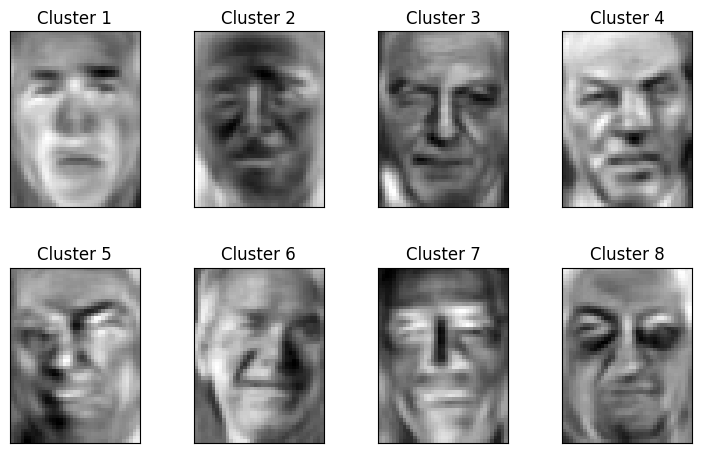

In [7]:
# 结果可视化
# 定义绘制面部图像的函数
def plot_faces(images, titles, h, w, n_row=2, n_col=4):
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(len(images)):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

# 获取每个聚类的中心（均值）
mean_faces_pca = gmm.means_

# 将PCA空间中的均值逆变换回原始空间
mean_faces_original = pca.inverse_transform(mean_faces_pca)

# 为每个聚类中心设置标题
titles = [f'Cluster {i + 1}' for i in range(n_clusters)]

# 绘制聚类中心面部图像
plot_faces(mean_faces_original, titles, h, w, n_row=(n_clusters//4)+1, n_col=4)
plt.show()

### 2. 自己实现高斯混合模型对电子商务数据进行聚类

#### 2.1 构建高斯混合聚类学习器

In [8]:
from scipy.stats import multivariate_normal
class GaussianMixture:
    def __init__(self,k_num=3,iter_times=100):
        self.k = k_num
        self.alpha = None # (k,) 混合系数
        self.miu = None # (k,dim) 均值 
        self.sigma = None #(k,dim,dim) 协方差矩阵
        self.gamma = None #(n,k) 样本属于k个高斯分布的概率

        self.dim = 0
        self.n = 0

        self.maxiter = iter_times
    
    # def gaussian_function(self,X,miu,sigma):
    #     return np.exp(-0.5 * np.sum((X-miu) @ np.linalg.inv(sigma) * (X-miu), axis=1)) / (2*np.pi**(self.dim/2) * np.linalg.det(sigma)**0.5)
    def gaussian_function(self,X,miu,sigma):
        """
        计算多维高斯分布的概率密度函数
        输入：
            X: 输入数据 (n, dim)
            miu: 均值向量 (dim,)
            sigma: 协方差矩阵 (dim, dim)
        输出：
            0到1的浮点数, 高斯分布的概率密度值
        """
        return multivariate_normal.pdf(X, mean=miu, cov=sigma)
    
    def Estep(self,data):
        '''
        E步: 计算每个样本属于每个高斯分布的概率
        输入：
            data: (n,dim)
        输出：
            无返回值, 对self.gamma: (n,k)进行迭代
        '''
        for i in range(self.k):
            self.gamma[:,i] = self.alpha[i] * self.gaussian_function(data,self.miu[i],self.sigma[i]) 
        self.gamma /= np.sum(self.gamma,axis=1,keepdims=True)

    def Mstep(self, data):
        '''
        M步: 更新参数
        输入：
            data: (n,dim)
        输出：
            无返回值, 对self.miu, self.sigma, self.alpha进行迭代
        '''
        gamma_sum = np.sum(self.gamma, axis=0)
        self.miu = np.dot(self.gamma.T, data) / gamma_sum[:, None]
        self.sigma = np.zeros((self.k, self.dim, self.dim))
        for i in range(self.k):
            x = data - self.miu[i]
            self.sigma[i] = np.dot(self.gamma[:, i] * x.T, x) / gamma_sum[i]
        self.alpha = gamma_sum / self.n
    
    # 归一化
    def Normalization(self,data):
        return (data - np.min(data)) / (np.max(data) - np.min(data))

    def fit(self,data):
        data = self.Normalization(data)
        # 初始化参数
        self.n,self.dim = data.shape
        self.alpha = np.ones(self.k)/self.k
        self.miu = np.random.rand(self.k,self.dim)
        self.sigma = np.array([np.identity(self.dim)]*self.k)
        self.gamma = np.random.rand(self.n,self.k)

        # EM迭代
        for _ in range(self.maxiter):
            self.Estep(data)
            self.Mstep(data)

In [9]:
# 数据集构建
# 设置随机种子以确保结果可重复
np.random.seed(42)

# 生成第一个高斯分布的数据
mean1 = [0, 0, 0, 0, 0]  # 均值向量
cov1 = np.eye(5)  # 协方差矩阵（单位矩阵）
data1 = np.random.multivariate_normal(mean1, cov1, 100)  # 生成100个样本

# 生成第二个高斯分布的数据
mean2 = [5, 5, 5, 5, 5]
cov2 = np.eye(5)
data2 = np.random.multivariate_normal(mean2, cov2, 100)

# 生成第三个高斯分布的数据
mean3 = [0, 5, 0, 5, 0]
cov3 = np.eye(5)
data3 = np.random.multivariate_normal(mean3, cov3, 100)

# 生成第四个高斯分布的数据
mean4 = [5, 0, 5, 0, 5]
cov4 = np.eye(5)
data4 = np.random.multivariate_normal(mean4, cov4, 100)

# 生成第五个高斯分布的数据
mean5 = [2.5, 2.5, 2.5, 2.5, 2.5]
cov5 = np.eye(5)
data5 = np.random.multivariate_normal(mean5, cov5, 100)

# 合并所有生成的数据
data = np.vstack((data1, data2, data3, data4, data5))
np.random.shuffle(data)  # 打乱数据顺序

In [10]:
# 标准化
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data)  # 标准化数据，使其均值为0，标准差为1

In [11]:
# 降维
pca = PCA(n_components=2)  # 初始化PCA，降到2维
data_2d = pca.fit_transform(data_normalized)  # 对标准化后的数据进行PCA降维

In [12]:
gmm = GaussianMixture(k_num=5)
gmm.fit(data_normalized)

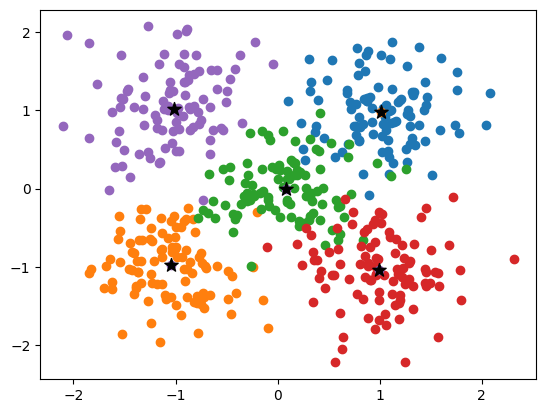

In [13]:
# 聚类结果可视化
labels = np.argmax(gmm.gamma,axis=1)
gmm.centers = data_normalized[:gmm.k]
for k in range(gmm.k):
    plt.scatter(data_normalized[labels==k][:,0],data_normalized[labels==k][:,1])
    if(labels[labels == k].size > 0):
        gmm.centers[k] = np.mean(data_normalized[labels==k], axis=0)
plt.scatter(gmm.centers[:,0],gmm.centers[:,1],c='black',marker='*',s=100)

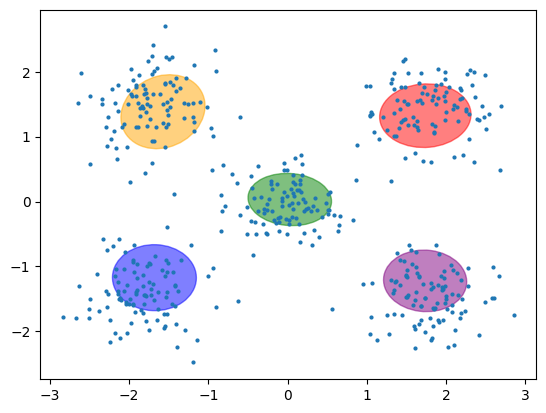

In [14]:
# 另一种可视化方式

from matplotlib.patches import Ellipse
fig, ax = plt.subplots()
colors = ['red', 'blue', 'green', 'purple', 'orange']  # 确保颜色数量足够

# 在学习时是根据归一化的数据进行迭代的，参数学的是归一化后的分布
# 需要反归一化
data_min = np.min(data_normalized, axis=0)
data_max = np.max(data_normalized, axis=0)

for i, (mean, cov, color) in enumerate(zip(gmm.miu, gmm.sigma, colors)):
    # 反归一化
    mean = mean * (data_max - data_min) + data_min
    cov = cov * np.outer(data_max - data_min, data_max - data_min)
    
    mean_2d = pca.transform(mean.reshape(1, -1))[0]  # 将均值转换到2维空间
    cov_2d = pca.components_ @ cov @ pca.components_.T  # 将协方差矩阵转换到2维空间
    v, w = np.linalg.eigh(cov_2d[:2, :2])  # 计算特征值和特征向量
    v = 2. * np.sqrt(2.) * np.sqrt(np.abs(v))  # 确保特征值为正数
    u = w[0] / np.linalg.norm(w[0])  # 计算椭圆的旋转角度

    angle = np.arctan2(u[1], u[0])  # 使用更稳健的 arctan2
    angle = 180. * angle / np.pi  # 将角度转换为度数
    ell = Ellipse(mean_2d, v[0], v[1], angle=angle, color=color)  # 创建椭圆对象
    ell.set_alpha(0.5)  # 设置椭圆透明度
    ax.add_patch(ell)  # 在图上添加椭圆

ax.scatter(data_2d[:, 0], data_2d[:, 1], s=4)  # 绘制数据点